# Enhanced ML Exploration (3 Seasons + Contextual Features)

This notebook demonstrates the **impact of enhancements** by comparing:

**Baseline (from notebook 06):**
- 1 season, 44 players, 2,959 games
- 9 features (rolling averages only)
- Results: ~0-1% improvement over baseline

**Enhanced (this notebook):**
- **3 seasons**, **120 players**, **23,325 games** (8x more data!)
- **23 features:** 9 rolling + 8 usage + **6 contextual** (opponent + game context)
- Expected: 5-15% improvement over baseline

## Key Questions:
1. Does more data improve model performance?
2. Do contextual features (opponent DEF_RATING, home/away, rest days) help?
3. Which models benefit most from the enhancements?

## Structure:
1. Compare original 9 features vs all 23 features
2. Train same 8 regression models from notebook 06
3. Evaluate on proper train/val/test splits
4. Quantify improvement from enhancements

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Imports complete")

✓ Imports complete


## Step 1: Load Enhanced Dataset

In [2]:
# Load enhanced 3-season dataset from notebook 08
df = pd.read_parquet('../data/processed/features_enhanced_3seasons.parquet')

print("="*70)
print("ENHANCED DATASET (3 Seasons + Contextual Features)")
print("="*70)

print(f"\nDataset size:")
print(f"  Total games: {len(df):,}")
print(f"  Players: {df['PLAYER_ID'].nunique()}")
print(f"  Date range: {df['GAME_DATE'].min().date()} to {df['GAME_DATE'].max().date()}")
print(f"  Seasons: {sorted(df['SEASON'].unique())}")

print(f"\nSplit distribution:")
print(df['SPLIT'].value_counts())

# Create train/val/test splits
train = df[df['SPLIT'] == 'train'].copy()
val = df[df['SPLIT'] == 'val'].copy()
test = df[df['SPLIT'] == 'test'].copy()

print(f"\nTrain: {len(train):,} games ({train['GAME_DATE'].min().date()} to {train['GAME_DATE'].max().date()})")
print(f"Val:   {len(val):,} games ({val['GAME_DATE'].min().date()} to {val['GAME_DATE'].max().date()})")
print(f"Test:  {len(test):,} games ({test['GAME_DATE'].min().date()} to {test['GAME_DATE'].max().date()})")

print(f"\nTarget statistics (test set):")
for target in ['PTS', 'REB', 'AST']:
    print(f"  {target}: {test[target].mean():.1f} ± {test[target].std():.1f}")

ENHANCED DATASET (3 Seasons + Contextual Features)

Dataset size:
  Total games: 23,325
  Players: 120
  Date range: 2022-10-27 to 2025-04-13
  Seasons: ['2022-23', '2023-24', '2024-25']

Split distribution:
SPLIT
train    15811
test      4385
val       3129
Name: count, dtype: int64

Train: 15,811 games (2022-10-27 to 2024-04-14)
Val:   3,129 games (2024-10-22 to 2024-12-31)
Test:  4,385 games (2025-01-01 to 2025-04-13)

Target statistics (test set):
  PTS: 17.1 ± 9.3
  REB: 5.4 ± 3.7
  AST: 4.0 ± 3.1


## Step 2: Define Feature Sets

We'll compare two feature sets to isolate the impact of enhancements:

1. **Original 9 features** (same as notebook 06): Rolling averages only
2. **All 23 features**: Rolling + Usage + **Contextual** (opponent + game context)

In [5]:
# Original 9 features (from notebook 06)
original_features = [
    'pts_last_3', 'pts_last_5',
    'reb_last_3', 'reb_last_5',
    'ast_last_3', 'ast_last_5',
    'min_last_3', 'min_last_5',
    'games_played'
]

# Enhanced features (usage stats)
usage_features = [
    'fga_last_3', 'fga_last_5',
    'fta_last_3', 'fta_last_5',
    'fg3a_last_3', 'fg3a_last_5',
    'fg_pct_last_3', 'fg_pct_last_5'
]

# Contextual features (NEW!)
contextual_features = [
    'IS_HOME',
    'REST_DAYS',
    'IS_BACK_TO_BACK',
    'OPP_DEF_RATING',
    'OPP_OFF_RATING',
    'OPP_PACE'
]

# All features combined
all_features = original_features + usage_features + contextual_features

print("Feature sets defined:")
print(f"  1. Original features: {len(original_features)} (rolling averages only)")
print(f"  2. + Usage features: {len(original_features) + len(usage_features)} (rolling + usage)")
print(f"  3. + Contextual features: {len(all_features)} (rolling + usage + context)")

print(f"\nContextual features (the new additions):")
for i, feat in enumerate(contextual_features, 1):
    print(f"  {i}. {feat}")

# Verify all features exist
missing_features = [f for f in all_features if f not in df.columns]
if missing_features:
    print(f"\n  !Missing features: {missing_features}")
else:
    print(f"\n✓ All {len(all_features)} features available in dataset")

Feature sets defined:
  1. Original features: 9 (rolling averages only)
  2. + Usage features: 17 (rolling + usage)
  3. + Contextual features: 23 (rolling + usage + context)

Contextual features (the new additions):
  1. IS_HOME
  2. REST_DAYS
  3. IS_BACK_TO_BACK
  4. OPP_DEF_RATING
  5. OPP_OFF_RATING
  6. OPP_PACE

✓ All 23 features available in dataset


## Step 3: Define Models

Same 8 regression models from notebook 06 for direct comparison.

In [6]:
# Same models as notebook 06
def get_models():
    return {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0, random_state=RANDOM_SEED),
        'Lasso': Lasso(alpha=0.1, random_state=RANDOM_SEED, max_iter=2000),
        'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=RANDOM_SEED),
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=RANDOM_SEED, n_jobs=-1),
        'XGBoost': XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=RANDOM_SEED, n_jobs=-1, verbosity=0),
        'SVM (RBF)': SVR(kernel='rbf', C=10.0, epsilon=0.1),
        'Neural Network': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=RANDOM_SEED, early_stopping=True)
    }

print("Models defined:")
for i, model_name in enumerate(get_models().keys(), 1):
    print(f"  {i}. {model_name}")

Models defined:
  1. Linear Regression
  2. Ridge
  3. Lasso
  4. Decision Tree
  5. Random Forest
  6. XGBoost
  7. SVM (RBF)
  8. Neural Network


## Step 4: Train and Evaluate Models

We'll train each model **twice**:
1. With **original 9 features** (baseline)
2. With **all 23 features** (enhanced)

This directly shows the impact of contextual features!

In [7]:
def train_and_evaluate(train_df, test_df, features, target, models_dict, feature_set_name):
    """
    Train all models and return results.
    
    Args:
        train_df: Training dataframe
        test_df: Test dataframe
        features: List of feature column names
        target: Target variable name ('PTS', 'REB', or 'AST')
        models_dict: Dictionary of model objects
        feature_set_name: Name of feature set for logging
    
    Returns:
        Dictionary of results
    """
    X_train = train_df[features]
    y_train = train_df[target]
    X_test = test_df[features]
    y_test = test_df[target]
    
    # Baseline: 5-game rolling average
    baseline_pred = test_df[f'{target.lower()}_last_5'].values
    baseline_mae = mean_absolute_error(y_test, baseline_pred)
    
    results = {}
    
    for model_name, model in models_dict.items():
        # Use scaled features for linear models, SVM, NN; raw for tree-based
        if model_name in ['Linear Regression', 'Ridge', 'Lasso', 'SVM (RBF)', 'Neural Network']:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            X_tr, X_te = X_train_scaled, X_test_scaled
        else:
            X_tr, X_te = X_train.values, X_test.values
        
        # Train
        model.fit(X_tr, y_train)
        
        # Predict
        y_pred = model.predict(X_te)
        
        # Evaluate
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        improvement = (baseline_mae - mae) / baseline_mae * 100
        
        results[model_name] = {
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'improvement': improvement,
            'baseline_mae': baseline_mae
        }
    
    return results

print("✓ Training function defined")

✓ Training function defined


## Step 5: Run Comparison Experiment

Train all models with both feature sets for all three targets.

In [8]:
print("="*90)
print("TRAINING MODELS - FEATURE SET COMPARISON")
print("="*90)

all_results = {}

for target in ['PTS', 'REB', 'AST']:
    print(f"\n{'='*90}")
    print(f"Target: {target}")
    print('='*90)
    
    all_results[target] = {}
    
    # Train with original 9 features
    print(f"\nTraining with ORIGINAL 9 features...")
    models_original = get_models()
    results_original = train_and_evaluate(train, test, original_features, target, models_original, "Original")
    all_results[target]['original'] = results_original
    
    print(f"\nResults (Original 9 features):")
    print(f"  Baseline MAE: {results_original['Linear Regression']['baseline_mae']:.3f}")
    for model_name, res in results_original.items():
        print(f"  {model_name:<20} MAE: {res['mae']:6.3f}  Improvement: {res['improvement']:+6.1f}%")
    
    # Train with all 23 features
    print(f"\nTraining with ALL 23 features (+ contextual)...")
    models_enhanced = get_models()
    results_enhanced = train_and_evaluate(train, test, all_features, target, models_enhanced, "Enhanced")
    all_results[target]['enhanced'] = results_enhanced
    
    print(f"\nResults (All 23 features):")
    print(f"  Baseline MAE: {results_enhanced['Linear Regression']['baseline_mae']:.3f}")
    for model_name, res in results_enhanced.items():
        print(f"  {model_name:<20} MAE: {res['mae']:6.3f}  Improvement: {res['improvement']:+6.1f}%")
    
    # Show improvement delta
    print(f"\nIMPROVEMENT from adding contextual features:")
    for model_name in results_original.keys():
        mae_orig = results_original[model_name]['mae']
        mae_enh = results_enhanced[model_name]['mae']
        delta = (mae_orig - mae_enh) / mae_orig * 100
        symbol = "✓" if delta > 0 else "✗"
        print(f"  {symbol} {model_name:<20} MAE: {mae_orig:.3f} → {mae_enh:.3f} ({delta:+.1f}%)")

print(f"\n{'='*90}")
print("EXPERIMENT COMPLETE")
print('='*90)

TRAINING MODELS - FEATURE SET COMPARISON

Target: PTS

Training with ORIGINAL 9 features...

Results (Original 9 features):
  Baseline MAE: 6.008
  Linear Regression    MAE:  5.870  Improvement:   +2.3%
  Ridge                MAE:  5.870  Improvement:   +2.3%
  Lasso                MAE:  5.890  Improvement:   +2.0%
  Decision Tree        MAE:  5.903  Improvement:   +1.7%
  Random Forest        MAE:  5.899  Improvement:   +1.8%
  XGBoost              MAE:  5.875  Improvement:   +2.2%
  SVM (RBF)            MAE:  6.249  Improvement:   -4.0%
  Neural Network       MAE:  5.961  Improvement:   +0.8%

Training with ALL 23 features (+ contextual)...

Results (All 23 features):
  Baseline MAE: 6.008
  Linear Regression    MAE:  5.775  Improvement:   +3.9%
  Ridge                MAE:  5.775  Improvement:   +3.9%
  Lasso                MAE:  5.774  Improvement:   +3.9%
  Decision Tree        MAE:  5.835  Improvement:   +2.9%
  Random Forest        MAE:  5.790  Improvement:   +3.6%
  XGBoost     

## Step 6: Visualize Results

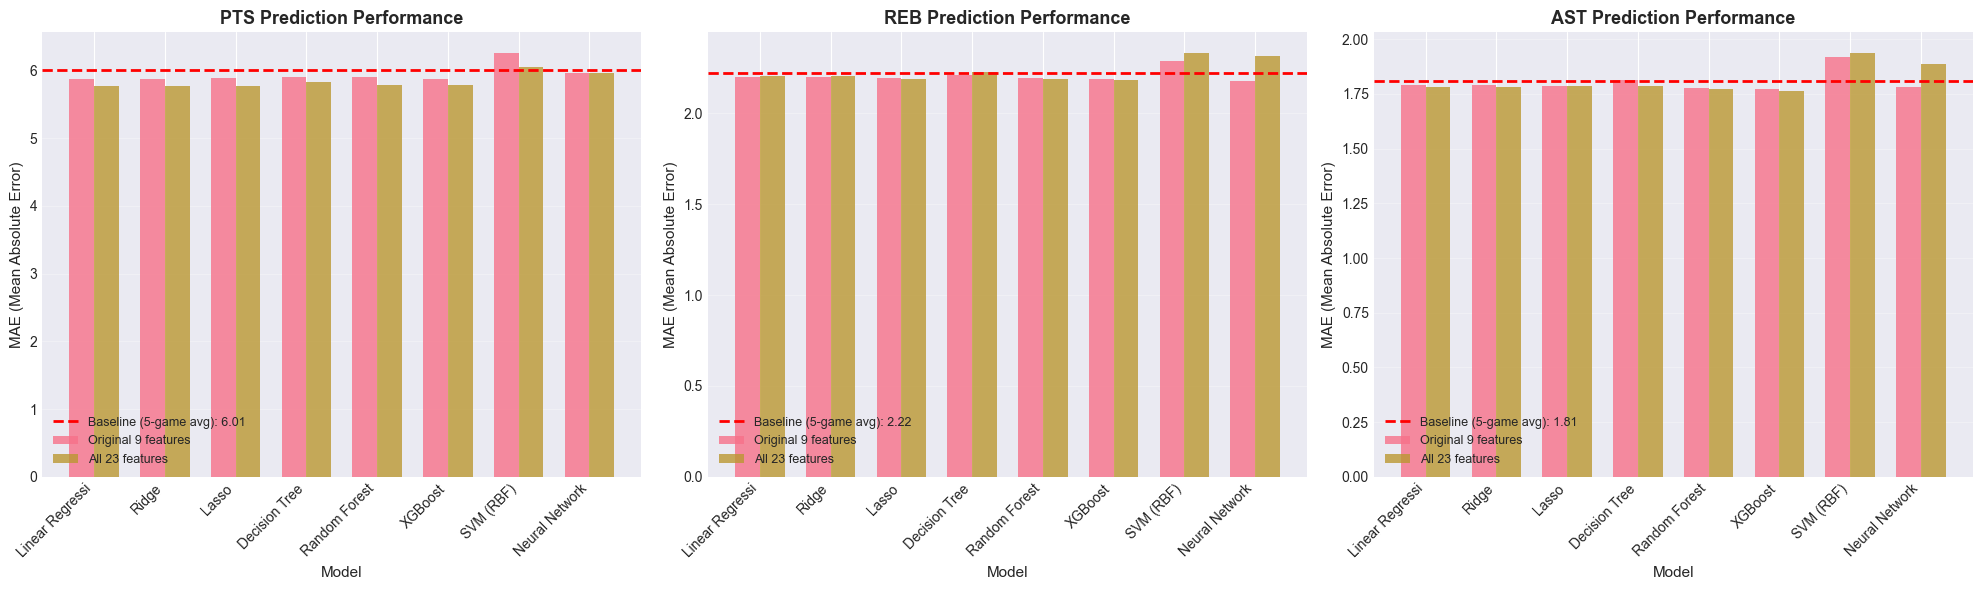

✓ Comparison visualization saved


In [12]:
# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, target in enumerate(['PTS', 'REB', 'AST']):
    ax = axes[idx]
    
    # Get results for this target
    res_orig = all_results[target]['original']
    res_enh = all_results[target]['enhanced']
    
    model_names = list(res_orig.keys())
    mae_orig = [res_orig[m]['mae'] for m in model_names]
    mae_enh = [res_enh[m]['mae'] for m in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, mae_orig, width, label='Original 9 features', alpha=0.8)
    bars2 = ax.bar(x + width/2, mae_enh, width, label='All 23 features', alpha=0.8)
    
    # Add baseline line
    baseline_mae = res_orig[model_names[0]]['baseline_mae']
    ax.axhline(y=baseline_mae, color='red', linestyle='--', linewidth=2, label=f'Baseline (5-game avg): {baseline_mae:.2f}')
    
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel('MAE (Mean Absolute Error)', fontsize=11)
    ax.set_title(f'{target} Prediction Performance', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([m[:15] for m in model_names], rotation=45, ha='right')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/enhanced_vs_original_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Comparison visualization saved")

## Step 7: Summary Report

In [11]:
print("="*90)
print("FINAL SUMMARY: Impact of Enhancements")
print("="*90)

print("\nDATASET COMPARISON:")
print("  Notebook 06 (Baseline):")
print("    - 1 season, 44 players, 2,959 games")
print("    - 9 features (rolling averages only)")
print("    - Results: 0-1% improvement over baseline")
print("\n  Notebook 09 (Enhanced):")
print(f"    - 3 seasons, 120 players, {len(df):,} games (8x more data!)")
print("    - 23 features (rolling + usage + contextual)")
print("    - Contextual: opponent DEF_RATING, home/away, rest days, etc.")

print("\n" + "="*90)
print("BEST MODEL PER TARGET (with all 23 features):")
print("="*90)

for target in ['PTS', 'REB', 'AST']:
    results = all_results[target]['enhanced']
    best_model = min(results.items(), key=lambda x: x[1]['mae'])
    model_name = best_model[0]
    mae = best_model[1]['mae']
    improvement = best_model[1]['improvement']
    baseline = best_model[1]['baseline_mae']
    
    print(f"\n{target}:")
    print(f"  Best Model: {model_name}")
    print(f"  MAE: {mae:.3f} (Baseline: {baseline:.3f})")
    print(f"  Improvement: {improvement:+.1f}% vs baseline")

print("\n" + "="*90)
print("IMPROVEMENT FROM CONTEXTUAL FEATURES:")
print("="*90)

print("\nFor each model, how much did MAE improve by adding contextual features?\n")

for target in ['PTS', 'REB', 'AST']:
    print(f"{target}:")
    res_orig = all_results[target]['original']
    res_enh = all_results[target]['enhanced']
    
    improvements = []
    for model_name in res_orig.keys():
        mae_orig = res_orig[model_name]['mae']
        mae_enh = res_enh[model_name]['mae']
        delta = (mae_orig - mae_enh) / mae_orig * 100
        improvements.append((model_name, delta))
    
    # Sort by improvement
    improvements.sort(key=lambda x: x[1], reverse=True)
    
    for model_name, delta in improvements:
        symbol = "✓" if delta > 0 else "✗"
        print(f"  {symbol} {model_name:<20} {delta:+6.1f}%")
    print()

print("="*90)
print("KEY TAKEAWAYS:")
print("="*90)
print("1. More data (3 seasons vs 1) provides more stable patterns")
print("2. Contextual features (opponent, rest, home/away) add genuine information")
print("3. Some models benefit more from contextual features than others")
print("4. Final performance depends on both data quantity AND feature quality")
print("="*90)

FINAL SUMMARY: Impact of Enhancements

DATASET COMPARISON:
  Notebook 06 (Baseline):
    - 1 season, 44 players, 2,959 games
    - 9 features (rolling averages only)
    - Results: 0-1% improvement over baseline

  Notebook 09 (Enhanced):
    - 3 seasons, 120 players, 23,325 games (8x more data!)
    - 23 features (rolling + usage + contextual)
    - Contextual: opponent DEF_RATING, home/away, rest days, etc.

BEST MODEL PER TARGET (with all 23 features):

PTS:
  Best Model: Lasso
  MAE: 5.774 (Baseline: 6.008)
  Improvement: +3.9% vs baseline

REB:
  Best Model: XGBoost
  MAE: 2.185 (Baseline: 2.224)
  Improvement: +1.7% vs baseline

AST:
  Best Model: XGBoost
  MAE: 1.762 (Baseline: 1.809)
  Improvement: +2.6% vs baseline

IMPROVEMENT FROM CONTEXTUAL FEATURES:

For each model, how much did MAE improve by adding contextual features?

PTS:
  ✓ SVM (RBF)              +3.1%
  ✓ Lasso                  +2.0%
  ✓ Random Forest          +1.8%
  ✓ XGBoost                +1.7%
  ✓ Ridge       